In [23]:

# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, probplot
import warnings

In [24]:
#read in the data file
track_df = pd.read_csv("dataset.csv")

In [25]:
#rows and columns of table
track_df.shape

(114000, 21)

In [26]:
#number of categorical variables
cat_num = 0
for dtype in track_df.dtypes:
    if dtype == "object":
        cat_num = cat_num + 1

In [27]:
print("# of categorical variables:", cat_num)

#rest of the columns are numeric
numeric_vars = track_df.shape[1] - cat_num - 2 #subtract 2 columns for number and track id columns
print("# of numeric variables:", numeric_vars) 

# of categorical variables: 5
# of numeric variables: 14


In [28]:
track_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Handle Missing Data

In [29]:
#remove the unnamed 'order' column
track_df = track_df.drop(columns=["Unnamed: 0","album_name","track_name","artists"])
# missing data
total = track_df.isnull().sum().sort_values(ascending=False)
percent = (track_df.isnull().sum() / track_df.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
track_id,0,0.0
speechiness,0,0.0
time_signature,0,0.0
tempo,0,0.0
valence,0,0.0
liveness,0,0.0
instrumentalness,0,0.0
acousticness,0,0.0
mode,0,0.0
popularity,0,0.0


Since we do not need to worry about missing album names, track names, or artist names, nothing needs to be changed here. 

In [30]:
# We are checking to see if any columns are largely homogeneous
# Homogeneous columns provide no value to our model and can sometimes lead to overfitting
print("Categorical Columns Mode Frequency")

cat_columns = track_df.select_dtypes(include=["object"]).columns

mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])

for col in cat_columns:
    mode_value = track_df[col].mode().values[0]
    mode_freq = (track_df[col] == mode_value).mean()
    row_data = pd.DataFrame([{"column_name": col, "mode_frequency": mode_freq}])
    mode_freq_df = pd.concat([mode_freq_df,row_data], ignore_index= True)
mode_freq_df.sort_values("mode_frequency", ascending=False).head(10)

Categorical Columns Mode Frequency


/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_22152/2119238300.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mode_freq_df = pd.concat([mode_freq_df,row_data], ignore_index= True)


,column_name,mode_frequency
1,track_genre,0.008772
0,track_id,0.000079


Almost no Homogeneity within this dataset, so there is nothing to filter out!

In [31]:
# Check remaining missing values if any
all_data_na = track_df.isnull().sum() / len(track_df)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(
    ascending=False
)
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head()

,Missing Ratio


Handling non 0-1 range values:
certain columns (i.e tempo, loudness) have values that are not within a [0,1] range. We will use minmax scaling to bring it to a [0,1] range

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the 'tempo' and 'loudness' column to a 2D array as required by MinMaxScaler
tempo_values = track_df['tempo'].values.reshape(-1, 1)

loudness_values = track_df['loudness'].values.reshape(-1,1)
# Fit the scaler to the tempo and loudness values and transform them
scaled_tempo = scaler.fit_transform(tempo_values)
scaled_loudness = scaler.fit_transform(loudness_values)


# Replace the original 'tempo' and 'loudness' column with the scaled values
track_df['tempo'] = scaled_tempo
track_df['loudness'] = scaled_loudness
# Now the 'tempo' and 'loudness' column values are scaled between 0 and 1

[[0.79139152]
 [0.59737713]
 [0.73612267]
 ...
 [0.71464773]
 [0.71475871]
 [0.72742911]]


Handling Outliers

Get numerical cols first

In [34]:
numerical_columns = []

for col, dtype in track_df.dtypes.items():
    if dtype == "float64":
        numerical_columns.append(col)

print("Numerical Columns:", numerical_columns)

Numerical Columns: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


Now plot those to see which may have outlier vals

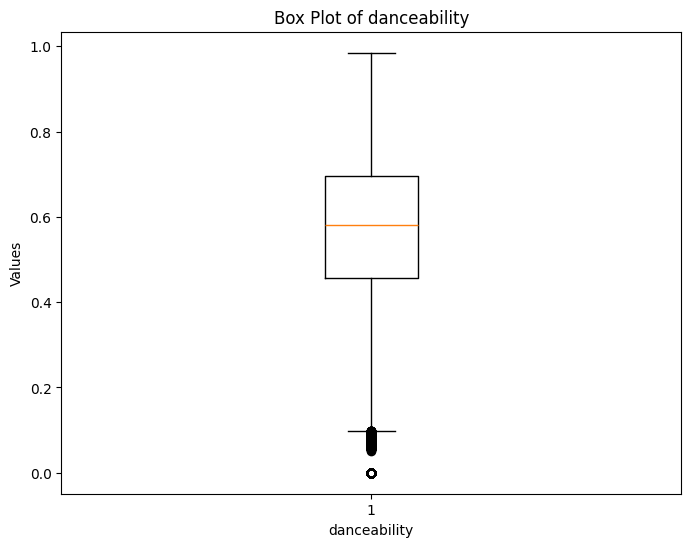

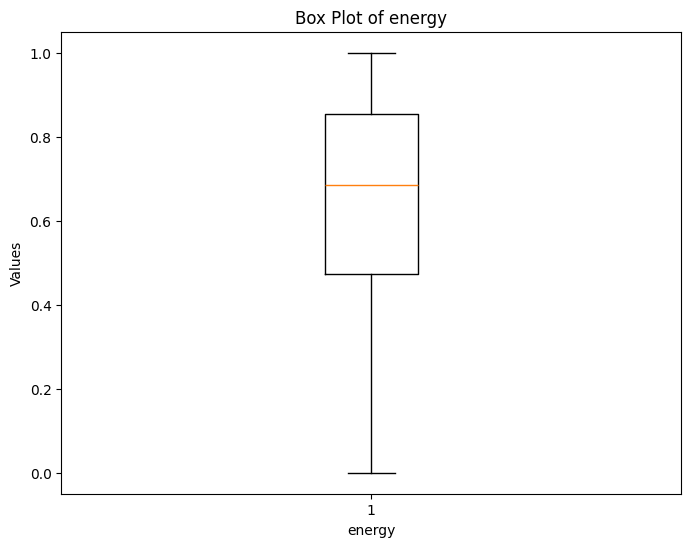

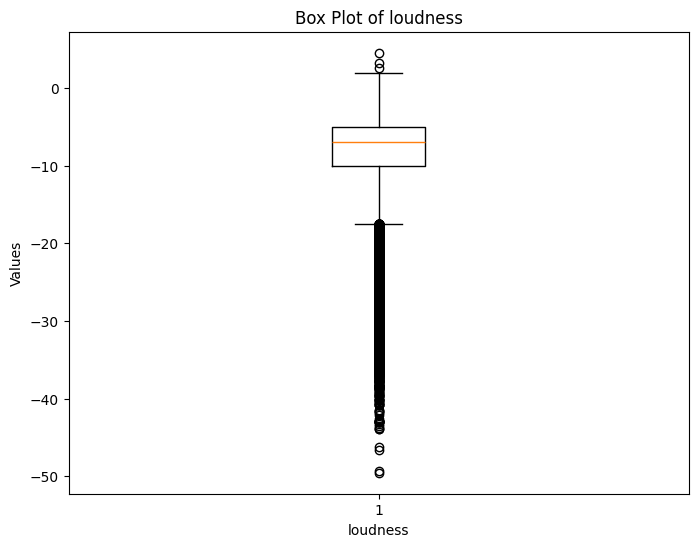

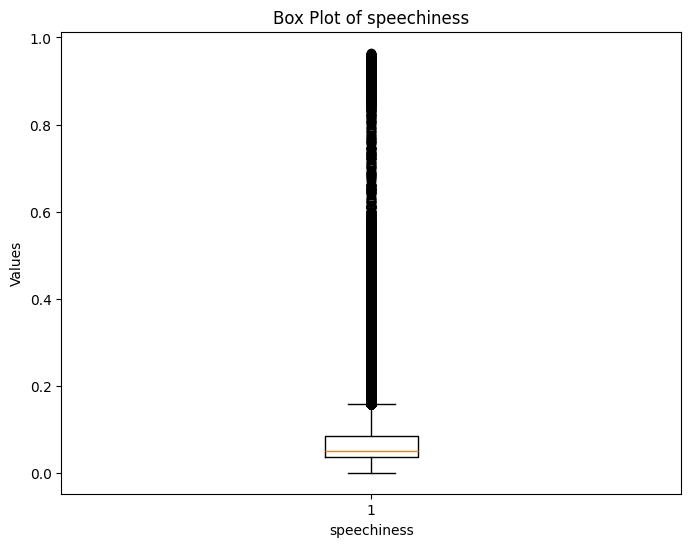

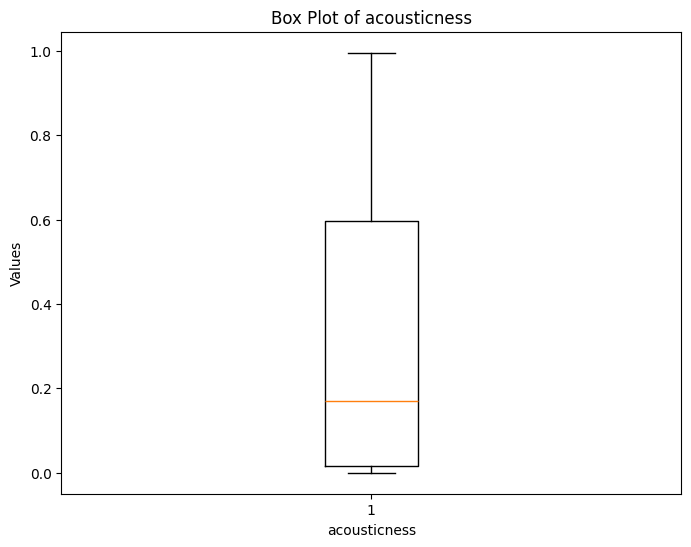

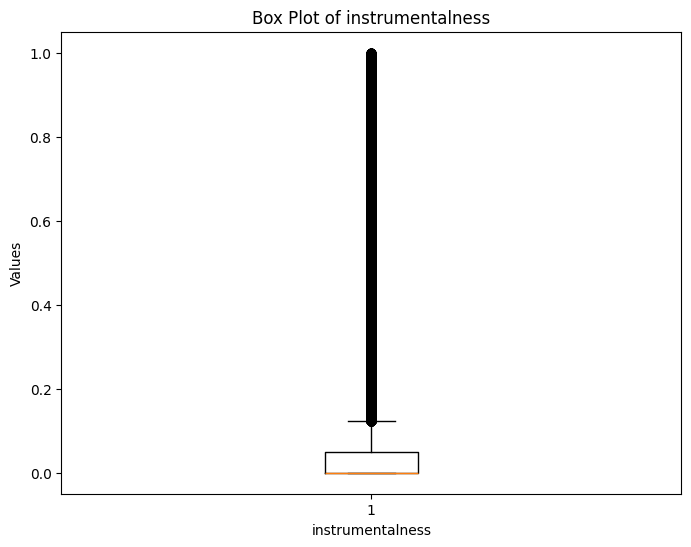

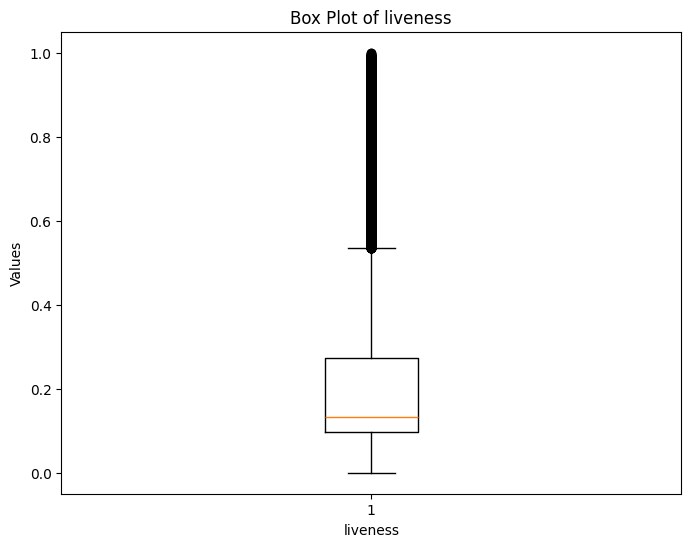

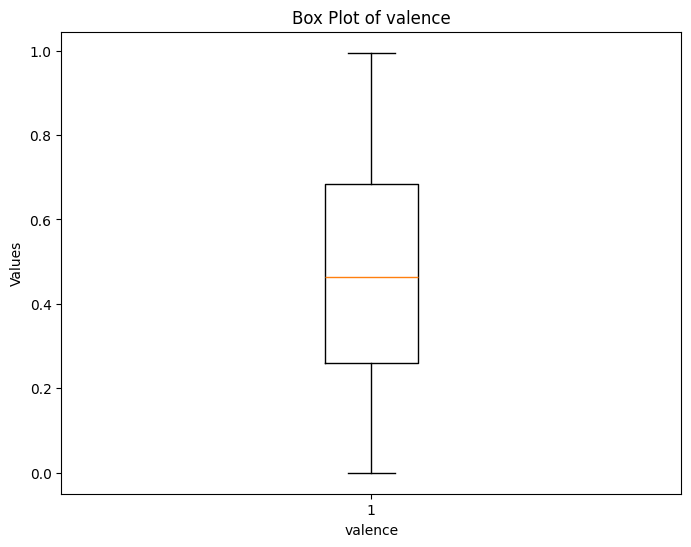

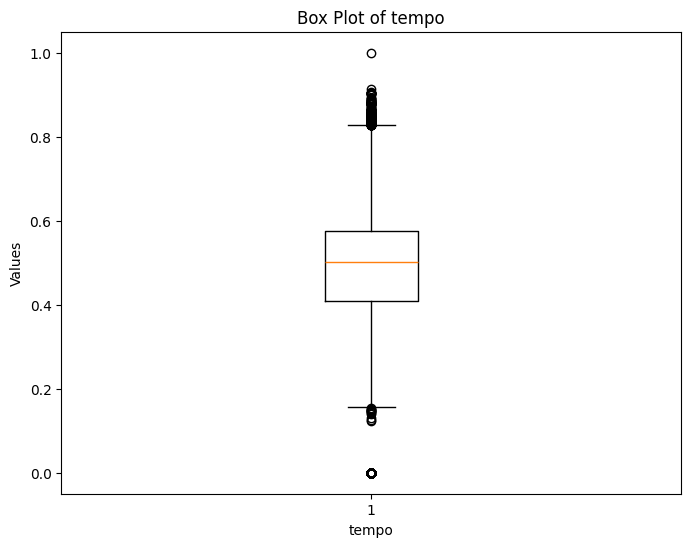

In [41]:

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.title(f"Box Plot of {col}")
    plt.boxplot(track_df[col])
    plt.xlabel(col)
    plt.ylabel("Values")
    plt.show()

Lets graph the most irregular columns to their genre to see if there are many outliers, this can lead to overfitting. 

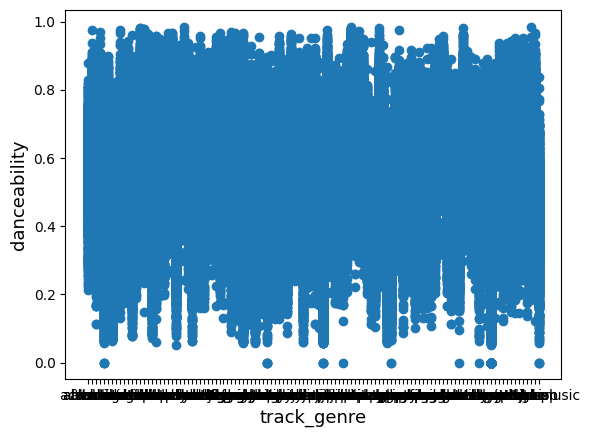

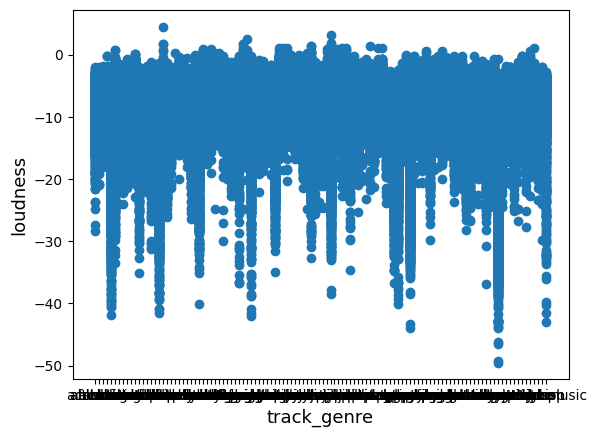

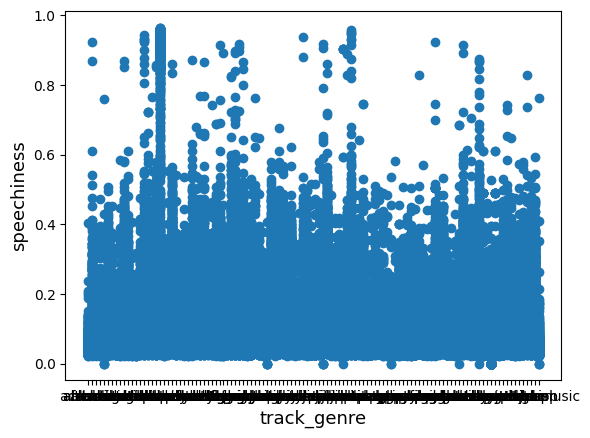

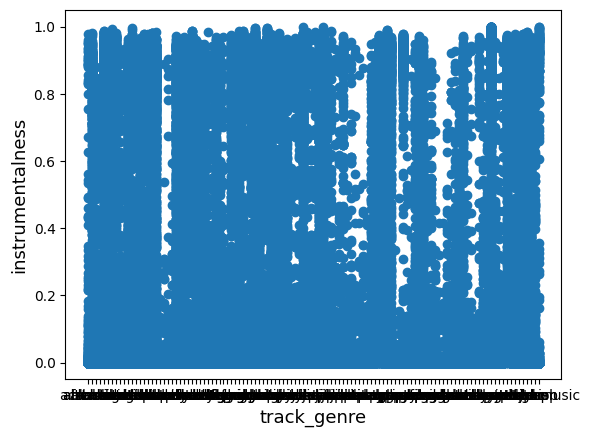

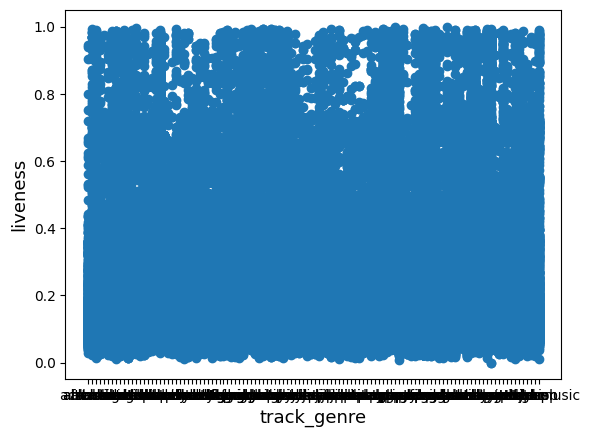

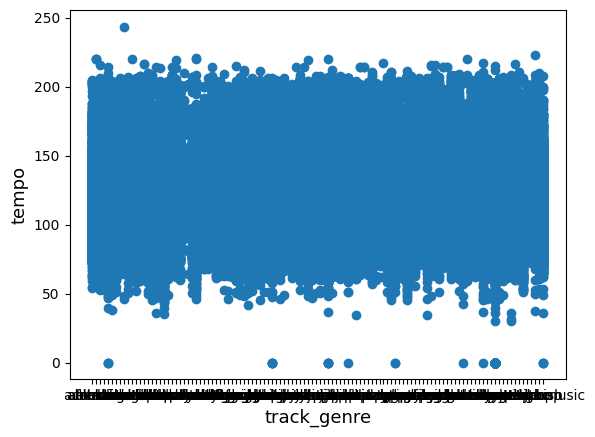

In [37]:
potential_outliers = ["danceability", "loudness", "speechiness", "instrumentalness", "liveness", "tempo"]
for col in potential_outliers:
    fig, ax = plt.subplots()
    ax.scatter(x=track_df["track_genre"], y=track_df[col])
    plt.ylabel(col, fontsize=13)
    plt.xlabel("track_genre", fontsize=13)
    plt.show()